In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.misc import derivative
from scipy.optimize import minimize

In [52]:
def atmo_event_rate(energy, cos_theta, sin2theta=0.9, dm2=2.4e-3):
    flux = 1e5*energy**-1.7 # the true neutrino flux is steeper, this takes into account 
                            # neutrino cross-section, which is proportional to E
                            # as well as that we are working with logarithmic energy bins    
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km

    # two flavor oscillation propability for muon disappearance - see wikipedia 
    osc_prop = 1-sin2theta * np.sin(1.27*dm2*l/energy) 

    return flux*osc_prop

def run_experiment(energy, cosdec, sin2theta=0.9, dm2=2.4e-3):
    x = np.array(energy.size)
    events=np.zeros(energy.size*cosdec.size)
    data = []

    i = 0
    for e in energy:
        for c in cosdec:
            mu = atmo_event_rate(e,c,sin2theta,dm2)
            sig = np.sqrt(mu)
            event_random = np.random.normal(mu,sig)
            events[i] = int(event_random) 
            data.append([e, c, events[i]])
            i=i+1
        
    df = pd.DataFrame(data, columns = ['Energy','cosdec','Events'])
                   
    return df

In [53]:
# lets generate one experiment, with 10 energy bins and 10 cos(declination) bins

cosdec =  np.linspace(0, 1, 10) # 10 steps in cos(declination) from 0 to 1 
log10_energy = np.linspace(1, 2, 10) # 10 steps in log10(energy) from 10 to 100 GeV
energy=10**log10_energy

# run the experiment 
events=run_experiment(energy,cosdec,0.9,2.4e-3)

def generate_experiment(N=1):
    cosdec =  np.linspace(0, 1, 10) # 10 steps in cos(declination) from 0 to 1 
    log10_energy = np.linspace(1, 2, 10) # 10 steps in log10(energy) from 10 to 100 GeV
    energy=10**log10_energy

    
    experiments = []
    
    if N == 1:
        events = run_experiment(energy, cosdec, 0.9, 2.4e-3)
        return events
    else:
        for i in range(N):
            events = run_experiment(energy, cosdec, 0.9, 2.4e-3)
            experiments.append(events)
        
        return experiments

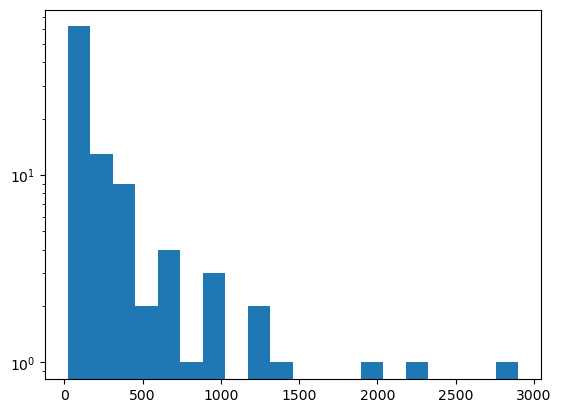

In [54]:
# 1. 

experiment_1 = generate_experiment()

plt.hist(experiment_1["Events"], bins = 20)
plt.yscale('log')
plt.show()

In [55]:
# 2. 

# Once want to fit a data, first need to creat a function
def fit_func(params, data):
    sin2theta,dm2  = params
    energy, cos_theta= data
    return atmo_event_rate(energy, cos_theta, sin2theta, dm2)

In [56]:
model = scipy.odr.Model(fit_func)
data = scipy.odr.RealData((experiment_1["Energy"],experiment_1["cosdec"]),experiment_1["Events"])
odr = scipy.odr.ODR(data, model, beta0=[0.9, 2.4e-3])
odr.set_job(fit_type=2)
out = odr.run()
popt = out.beta
perr = out.sd_beta
print("sin2theta = " + str(popt[0])+" ± "+str(perr[0]*1/np.sqrt(out.res_var)))
print("dm2 = " + str(popt[1])+" ± "+str(perr[1]*1/np.sqrt(out.res_var)))

sin2theta = 0.9001112733448143 ± 0.00017966539586203434
dm2 = 0.0024025078970603144 ± 2.1252102568210567e-07


In [57]:
def probability(sin2theta, dm2, energy, cosdec):
    if energy == 0:
        return 0
    l = 12e3 * cosdec # base line - max corresponds to diameter of the Earth 12e3 km
    osc_prob = 1-sin2theta * (np.sin(1.27*dm2*l/energy))**2 
    flux = 1e5*energy**-1.7
    return osc_prob*flux

def logprobability_sin(sin2theta, dm2, energy, cosdec):
    if energy == 0:
        return 0
    l = 12e3 * cosdec # base line - max corresponds to diameter of the Earth 12e3 km
    osc_prob = 1-sin2theta * (np.sin(1.27*dm2*l/energy))**2 
    flux = 1e5*energy**-1.7
    return np.log(osc_prob*flux)
def logprobability_dm2(dm2, sin2theta,  energy, cosdec):
    if energy == 0:
        return 0
    l = 12e3 * cosdec # base line - max corresponds to diameter of the Earth 12e3 km
    osc_prob = 1-sin2theta * (np.sin(1.27*dm2*l/energy))**2 
    flux = 1e5*energy**-1.7
    return np.log(osc_prob*flux)

def CramerRao_bound(energy, cosdec, events, sin2theta, dm2):
    #derivative of the Log Likelyhood with respect to dm2 and sin2theta
    dLLH_dm2 = 0
    dLLH_sin2theta = 0
    for i in range(len(energy)):
        dLLH_dm2 += (derivative(logprobability_dm2, dm2, dx=1e-6, args = (sin2theta, energy[i], cosdec[i])))**2 * probability(sin2theta, dm2, energy[i], cosdec[i])
        dLLH_sin2theta += (derivative(logprobability_sin, sin2theta,dx=1e-6, args = (dm2, energy[i], cosdec[i])))**2 * probability(sin2theta, dm2, energy[i], cosdec[i])
    return  1/dLLH_dm2, 1/dLLH_sin2theta

In [58]:
sigma_dm2 = np.sqrt(CramerRao_bound(experiment_1['Energy'], experiment_1['cosdec'], experiment_1['Events'], sin2theta=0.9, dm2=2.4e-3)[0])
sigma_sin2theta = np.sqrt(CramerRao_bound(experiment_1['Energy'], experiment_1['cosdec'], experiment_1['Events'], sin2theta=0.9, dm2=2.4e-3)[1])
print("V(dm2) >= " +str(sigma_dm2))
print("V(sin2theta) >= " + str(sigma_sin2theta))

V(dm2) >= 6.730937341672719e-06
V(sin2theta) >= 0.003113849901894136


In [59]:
sin2theta_100 = []
dm2_100 = []
sin2theta_sigma_100 = []
dm2_sigma_100 = []
k = 0

for i in range(1000):
    exp = generate_experiment()
    data = scipy.odr.RealData((exp["Energy"],exp["cosdec"]),exp["Events"])
    odr = scipy.odr.ODR(data, model, beta0=[0.9, 2.4e-3])
    odr.set_job(fit_type=2)
    out = odr.run()
    popt = out.beta
    perr = out.sd_beta
    sin2theta_100.append(popt[0])
    dm2_100.append(popt[1])
    sigma_dm2 = np.sqrt(CramerRao_bound(exp['Energy'], exp['cosdec'], exp['Events'], sin2theta=0.9, dm2=2.4e-3)[0])
    sigma_sin2theta = np.sqrt(CramerRao_bound(exp['Energy'], exp['cosdec'], exp['Events'], sin2theta=0.9, dm2=2.4e-3)[1])
    sin2theta_sigma_100.append(sigma_sin2theta)
    dm2_sigma_100.append(sigma_dm2)
    if (np.abs(dm2_100[i] - 2.4e-3) > sigma_dm2) or (np.abs(sin2theta_100[i] - 0.9) > sigma_sin2theta):
        k +=1
print('Fraction of points inside error ellipse: ' + str(k/1000))

Fraction of points inside error ellipse: 0.689


Text(0, 0.5, 'dm2')

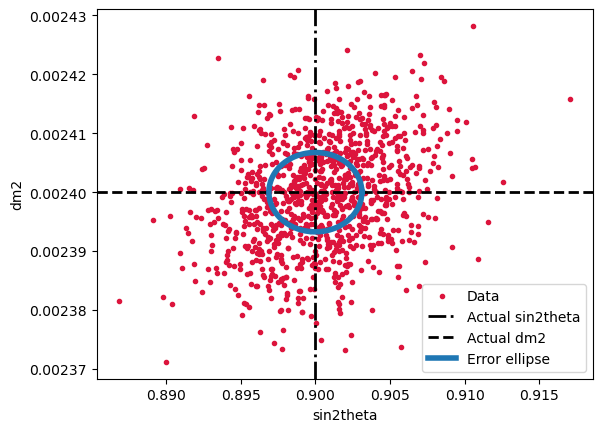

In [60]:
sin2theta=0.9
dm2=2.4e-3

from math import pi

u=0.9     #x-position of the center
v=2.4e-3   #y-position of the center
a=sigma_sin2theta    #radius on the x-axis
b=sigma_dm2    #radius on the y-axis

t = np.linspace(0, 2*pi, 100)

plt.plot(sin2theta_100, dm2_100, ".", c = 'crimson', label = 'Data')
plt.axvline(sin2theta, ls = '-.', c = 'k', label = 'Actual sin2theta', lw = 2)
plt.axhline(dm2, ls = '--', c = 'k', label = 'Actual dm2', lw = 2)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t), label = 'Error ellipse', lw = 4)


plt.legend()
plt.xlabel("sin2theta")
plt.ylabel("dm2")